all_positions:  29255


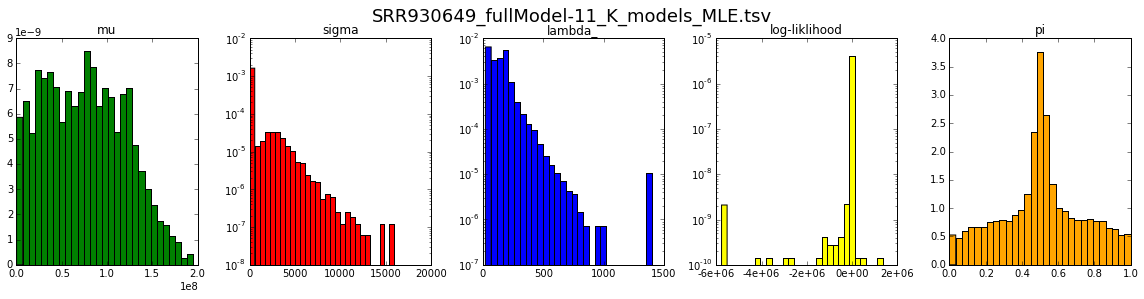

all_positions:  29255


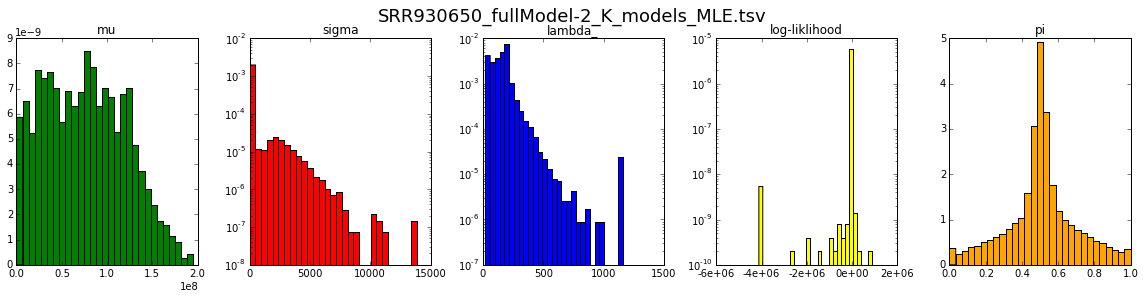

all_positions:  29255


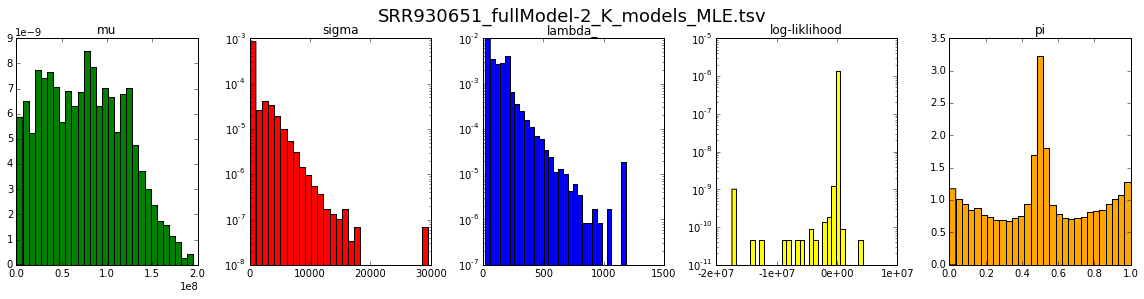

all_positions:  29255


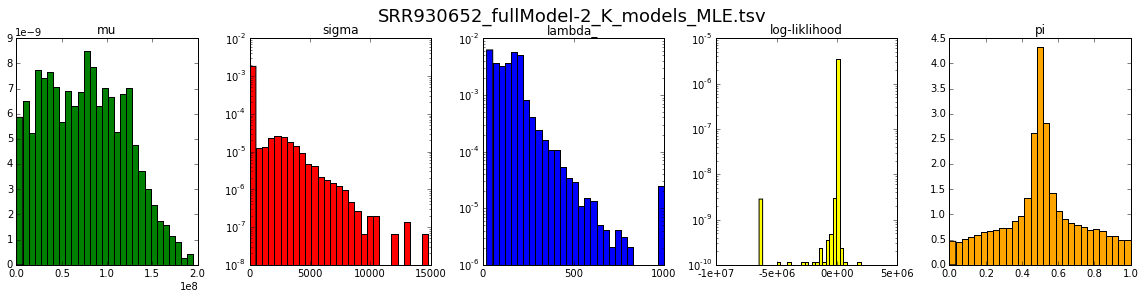

all_positions:  29255


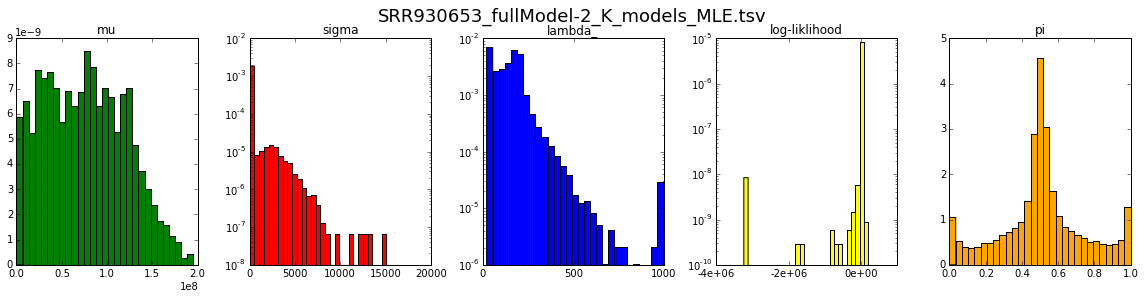

all_positions:  29255
all_positions:  29255


SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


In [72]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import sys
from scipy import stats
import matplotlib.ticker as mtick


### Pick the file directory
directory = '/media/ab/data/Research_Data/MM9_FullModel_Files/TEST/'
#directory = '/media/ab/data/Research_Data/MM9_FullModel_Files/'


### Sort the list of files
dir_list = sorted(os.listdir(directory))

### Initiate lists of variables for later use
all_mu = []
all_sigma = []
all_pi = []
all_lambda_= []
mu_pi_data = dict()
all_positions = dict()
def main():
    for filename in dir_list:
        if filename[-4:] == '.tsv':      ### Load only the TSV files
            x=open(directory+filename)   ### Open the file
            data = []                    ### Initiate the data list
            position = dict()            ### Initate the dict for each genomic interval
            for line in x:               ### For each line in the file x
                if line[0] is '>':       ### Look for indicator of new interval
                                         ### Load the basic interval info into the dict
                    position['name'] = line.split('|')[0][1:].strip('\n')
                    position['chromosome'] = (line.split('|')[1]).split(':')[0].strip('\n')
                    position['start'] = ((line.split('|')[1]).split(':')[1]).split('-')[0].strip('\n')
                    position['end'] = ((line.split('|')[1]).split(':')[1]).split('-')[1].strip('\n')
                    position['for_cov'] = (line.split('|')[2]).split(',')[0].strip('\n')
                    position['rev_cov'] = (line.split('|')[2]).split(',')[1].strip('\n')
                if line[0] is '~' and line[1] is '1':   ### Look for indicator of model 1
                    model_1 = dict()                    ### Init the dict for model 1
                    model_1['log-likelihood'] = (line.split('\t')[0]).split(',')[1].strip('\n')
                    model_1['mu_k'] = line.split('\t')[1].strip('\n')
                    model_1['sigma_k'] = line.split('\t')[2].strip('\n')
                    model_1['lambda_k'] = line.split('\t')[3].strip('\n')
                    model_1['pi_k'] = line.split('\t')[4].strip('\n')
                    model_1['fp_k'] = line.split('\t')[5].strip('\n')
                    model_1['w_[p,k]'] = (line.split('\t')[6]).split(',')[0].strip('\n')
                    model_1['w_[f,k]'] = (line.split('\t')[6]).split(',')[1].strip('\n')
                    model_1['w_[r,k]'] = (line.split('\t')[6]).split(',')[2].strip('\n')
                    model_1['b_[f,k]'] = line.split('\t')[7].strip('\n')
                    model_1['a_[r,k]'] = line.split('\t')[8].strip('\n')        
                    position['model_1'] = model_1       ### Add the model1 dict to the interval dict
                    data.append(position)               ### Append the interval dict to the data list
                    position = dict()                   ### Reset the interval dict

            lambda_ = []                 ### Init the list of all lambda values
            sigma = []                   ### Init the list of all sigma values
            mu = []                      ### Init the list of all mu values
            log_likelihood = []          ### Init the list of all log_likelihood values
            pi = []                      ### Init the list of all pi values
            mu_pi = []
            all_positions_local = []
            for i in data:               ### For each interval, copy the statistics to a separate list
                lambda_.append(float(i['model_1']['lambda_k']))
                sigma.append(float(i['model_1']['sigma_k']))
                mu.append(float(i['model_1']['mu_k']))
                log_likelihood.append(float(i['model_1']['log-likelihood']))
                pi.append(float(i['model_1']['pi_k']))
                mu_pi.append((float(i['model_1']['mu_k']), float(i['model_1']['pi_k'])))
                all_positions_local.append(i['chromosome']+":"+i['start']+"-"+i['end'])
            
            all_positions = list(set(all_positions_local))
            print "all_positions: ", len(all_positions)
            mu_pi_data[filename] = mu_pi
            ### Place all the stats in a tuple with the name of the dataset it came from, and add to list
            all_mu.append((filename, mu))
            all_sigma.append((filename, sigma)) 
            all_pi.append((filename, pi)) 
            all_lambda_.append((filename, lambda_)) 

            ### Remove any infinite values from the statistics and rename list
            x1 = remove_inf(mu)
            x2 = remove_inf(sigma)
            x3 = remove_inf(lambda_)
            x4 = remove_inf(log_likelihood)
            x5 = remove_inf(pi)
            
            ### Determine the number of datapoints
            sample_size = len(x1)
            
            ### Calculate the number of bins for the histogram
            x1_bins = len(x1) / 1000
            x2_bins = len(x2) / 1000
            x3_bins = len(x3) / 1000
            x4_bins = len(x4) / 1000
            x5_bins = len(x5) / 1000

            ### Make the five histogram axes for the plot
            fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=1, ncols=5, figsize=(16, 4))
            
            ### Add the data to the histograms
            ax1.hist(x1, x1_bins, normed=1, histtype='bar', color='green')
            ax1.set_title('mu')
            ax2.hist(x2, x2_bins, normed=1, histtype='bar', color='red', log=True)
            ax2.set_title('sigma')
            ax2.locator_params(axis='x',nbins=4)            
            ax3.hist(x3, x3_bins, normed=1, histtype='bar', facecolor='blue', log=True)
            ax3.set_title('lambda_')
            ax3.locator_params(axis='x',nbins=4)
            ax4.hist(x4, x4_bins, normed=1, histtype='bar', facecolor='yellow', log=True)
            ax4.set_title('log-liklihood')
            ax4.locator_params(axis='x',nbins=4)
            #ax4.set_xscale("log")
            ax4.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
            ax5.hist(x5, x5_bins, normed=1, histtype='bar', facecolor='orange')
            ax5.set_title('pi')

            ### Add a title to the plot
            fig.suptitle(filename, y=1.02, fontsize=18)

            ### Set the layout and show the plot
            plt.tight_layout()
            plt.show()
    
    print "all_positions: ", len(all_positions)
    print "all_positions: ", len(set(all_positions))
    #print mu_pi_data
    
def remove_inf(in_list):
    ### This function removes infinite values and replaces them with the maximum real number in the dataset
    out_list = []
    max_num = 0
    min_num = 0
    ### Determines the max and min real numbers in the dataset 
    for i in in_list:
        if i != float('inf') and i > max_num:
            max_num = i
        if -i != float('inf') and i < min_num:
            min_num = i
    ### Replace +infinity with the maximum value -infinity with the minimum value
    for i in in_list:
        if i == (float('inf')):
            out_list.append(max_num)
        elif -i == (np.inf):
            out_list.append(min_num)  
        else:
            out_list.append(i)           
    return out_list
        

if __name__ == "__main__":
    sys.exit(main())


In [55]:
from scipy.spatial import distance

pi_length = len(all_pi)
sigma_length = len(all_sigma)

ks_results = np.zeros((pi_length, pi_length))
ks_results_p = np.zeros((pi_length, pi_length))
ks_results_stat = np.zeros((pi_length, pi_length))
ks_results_p_log= np.zeros((pi_length, pi_length))
ks_results_stat_log = np.zeros((pi_length, pi_length))
euclidean_distance = np.zeros((pi_length, pi_length))

ks_labels = []
k = 0
for i in range(pi_length):
    for j in range(k):
        #ks_results[i][j] = scipy.stats.ks_2samp(all_sigma[i][1],all_sigma[j][1])
        ks_results_stat[i][j] = scipy.stats.ks_2samp(all_pi[i][1],all_pi[j][1])[0]
        ks_results_p[i][j] = scipy.stats.ks_2samp(all_pi[i][1],all_pi[j][1])[1]
        ks_results_stat_log[i][j] = np.log10([scipy.stats.ks_2samp(all_pi[i][1],all_pi[j][1])[0] ])
        ks_results_p_log[i][j] = np.log10([scipy.stats.ks_2samp(all_pi[i][1],all_pi[j][1])[1] ])
        euclidean_distance[i][j]  = distance.euclidean(all_pi[i][1],all_pi[j][1])
        #print i, " ", j
    ks_labels.append(all_pi[i][0])
    k += 1
    print k
    
print ks_labels        
#print ks_results
#print ks_results_p
#print ks_results_stat
#print euclidean_distance

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
#from matplotlib.colors import SymLogNorm

column_labels = ks_labels
row_labels = ks_labels

for dataset in [ks_results_stat, ks_results_p, ks_results_stat_log, ks_results_p_log, euclidean_distance]:    
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = ax.pcolormesh(dataset, cmap=plt.cm.Blues)
    print row_labels
    #ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_yticks(np.arange(len(row_labels))+.5)
    ax.set_xticks(np.arange(len(row_labels))+.5)
    ax.set_yticklabels([x[:9] for x in row_labels])
    ax.set_xticklabels([x[:9] for x in row_labels], rotation='vertical')
    plt.colorbar(heatmap)
    plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/home/ab/.local/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10


21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
['SRR930649_fullModel-11_K_models_MLE.tsv', 'SRR930650_fullModel-2_K_models_MLE.tsv', 'SRR930651_fullModel-2_K_models_MLE.tsv', 'SRR930652_fullModel-2_K_models_MLE.tsv', 'SRR930653_fullModel-2_K_models_MLE.tsv', 'SRR930654_fullModel-2_K_models_MLE.tsv', 'SRR930655_fullModel-2_K_models_MLE.tsv', 'SRR930656_fullModel-2_K_models_MLE.tsv', 'SRR930657_fullModel-2_K_models_MLE.tsv', 'SRR930658_fullModel-2_K_models_MLE.tsv', 'SRR930659_fullModel-2_K_models_MLE.tsv', 'SRR930660_fullModel-2_K_models_MLE.tsv', 'SRR930661_fullModel-2_K_models_MLE.tsv', 'SRR930662_fullModel-2_K_models_MLE.tsv', 'SRR930663_fullModel-2_K_models_MLE.tsv', 'SRR930664_fullModel-2_K_models_MLE.tsv', 'SRR930665_fullModel-2_K_models_MLE.tsv', 'SRR930666_fullModel-2_K_models_MLE.tsv', 'SRR930667_fullModel-2_K_models_MLE.tsv', 'SRR930668_fullModel-2_K_models_MLE.tsv', 'SRR930669_ful

In [65]:
row_labels = []
for i in sorted((mu_pi_data.keys())):
    row_labels.append(i)
    
mu_distances = np.zeros((len(all_mu), len(all_mu)))
print len(all_mu)
print mu_distances
max_len = (0, 0)
min_len = (0, 0)
for i in range(len(all_mu)):
    #print len(all_mu[i][1])
    if len(all_mu[i][1]) > max_len[1]:
        max_len = (i, len(all_mu[i][1]))
        print "max: ", max_len
    elif len(all_mu[i][1]) < min_len[1]:
        min_len = (i, len(all_mu[i][1]))
        print "min: ", min_len
k = 0       
for i in range(len(all_mu)):
    for j in range(k):
        mu_distances[i][j] = (sum((np.array(all_mu[i][1]) - np.array(all_mu[j][1]))))/max_len[1]
    k += 1
print mu_distances

68
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
max:  (0, 29255)
[[    0.             0.             0.         ...,     0.             0.
      0.        ]
 [  -38.40088031     0.             0.         ...,     0.             0.
      0.        ]
 [  -13.69907607    24.70180425     0.         ...,     0.             0.
      0.        ]
 ..., 
 [ -560.8984024   -522.49752209  -547.19932633 ...,     0.             0.
      0.        ]
 [ -565.33522805  -526.93434774  -551.63615198 ...,    -4.43682565     0.
      0.        ]
 [-1063.52658416 -1025.12570385 -1049.8275081  ...,  -502.62818177
   -498.19135612     0.        ]]


['SRR930649_fullModel-11_K_models_MLE.tsv', 'SRR930650_fullModel-2_K_models_MLE.tsv', 'SRR930651_fullModel-2_K_models_MLE.tsv', 'SRR930652_fullModel-2_K_models_MLE.tsv', 'SRR930653_fullModel-2_K_models_MLE.tsv', 'SRR930654_fullModel-2_K_models_MLE.tsv', 'SRR930655_fullModel-2_K_models_MLE.tsv', 'SRR930656_fullModel-2_K_models_MLE.tsv', 'SRR930657_fullModel-2_K_models_MLE.tsv', 'SRR930658_fullModel-2_K_models_MLE.tsv', 'SRR930659_fullModel-2_K_models_MLE.tsv', 'SRR930660_fullModel-2_K_models_MLE.tsv', 'SRR930661_fullModel-2_K_models_MLE.tsv', 'SRR930662_fullModel-2_K_models_MLE.tsv', 'SRR930663_fullModel-2_K_models_MLE.tsv', 'SRR930664_fullModel-2_K_models_MLE.tsv', 'SRR930665_fullModel-2_K_models_MLE.tsv', 'SRR930666_fullModel-2_K_models_MLE.tsv', 'SRR930667_fullModel-2_K_models_MLE.tsv', 'SRR930668_fullModel-2_K_models_MLE.tsv', 'SRR930669_fullModel-2_K_models_MLE.tsv', 'SRR930670_fullModel-2_K_models_MLE.tsv', 'SRR930671_fullModel-2_K_models_MLE.tsv', 'SRR930672_fullModel-2_K_models_

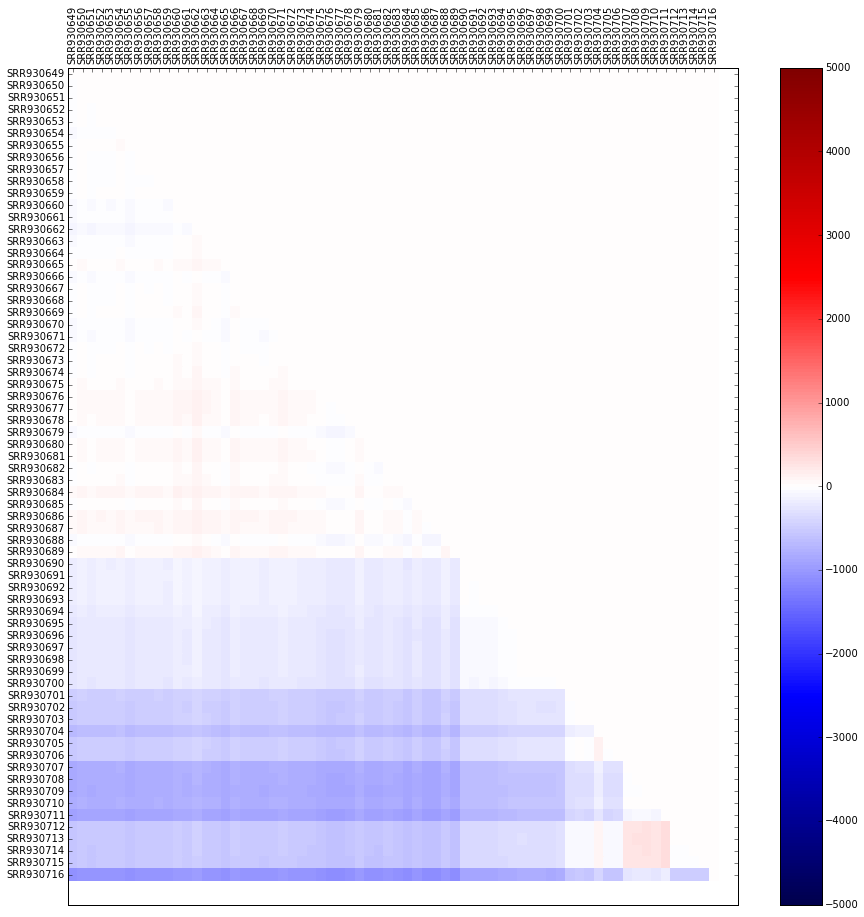

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
from pylab import *

#from matplotlib.colors import SymLogNorm

#column_labels = ks_labels
#row_labels = ks_labels

for dataset in [mu_distances]:    
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = ax.pcolormesh(dataset, norm=mpl.colors.Normalize(vmin=-5000, vmax=5000), cmap=plt.cm.seismic)
    print row_labels
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_yticks(np.arange(len(row_labels))+.5)
    ax.set_xticks(np.arange(len(row_labels))+.5)
    ax.set_yticklabels([x[:9] for x in row_labels])
    ax.set_xticklabels([x[:9] for x in row_labels], rotation='vertical')
    plt.colorbar(heatmap)
    plt.show()

In [59]:
row_labels = []
for i in sorted((mu_pi_data.keys())):
    row_labels.append(i)

k = 0       
for i in range(len(row_labels)):
    for j in range(k):
        mu_distances[i][j] = (sum((np.array(all_mu[i][1]) - np.array(all_mu[j][1]))))/max_len[1]
    k += 1

print (mu_pi_data['SRR930653_fullModel-2_K_models_MLE.tsv'][0])

IndexError: index 5 is out of bounds for axis 0 with size 5